### 서사형 사용자 상호작용 시스템 개발



#### ◎ 모델 파이프라인


1.[유저 행동 기록 DB]  ← 클릭, 투표 등 실시간 저장  
       ↓  
2.[감정 추론 모델 (Gemini)]  → 감정 분류 (이성적 관심, 우정, 호기심 등)  
       ↓  
3.[관계 구조화 모델]  → 유저 쌍별 감정/행동 기반 관계 지표 생성  
       ↓  
4.[문구 생성 시스템 (Prompt Template + Gemini)]  → 관계 상태 기반으로 서사 문구 동적 생성  
       ↓  
5.[사용자 피드백 UI] ← 실시간 메시지 노출


#### 질문 텍스트 감정 추론 


- 데이터 불러오기


In [1]:
import os 
import pandas as pd 
import mysql.connector
import dotenv
from dotenv import load_dotenv

load_dotenv()

host = os.getenv("DB_HOST")
user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")
database = os.getenv("DB_NAME")

# DB 연결정보
conn = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database=database
)
cursor = conn.cursor()

# 질문 테이블 조회
query = "SELECT id, question_text FROM polls_question"
cursor.execute(query)

# 결과 가져오기 
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]

# dataframe 생성
q_df = pd.DataFrame(rows, columns=columns)

cursor.close()
conn.close()


q_df.head(5)

,id,question_text
0,99,가장 신비한 매력이 있는 사람은?
1,100,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?"
2,101,미래의 틱톡커는?
3,102,여기서 제일 특이한 친구는?
4,103,가장 지켜주고 싶은 사람은?


In [39]:
q_df.to_csv("/home/twins032337/Final/data/questions.csv")

In [40]:
# 입력값 오류로 질문 텍스트가 "vote"인 행들 존재
len(q_df[q_df['question_text'] == "vote"])

# "vote"인 질문 제거 
q_df = q_df[q_df['question_text'] != "vote"]

# 확인 
q_df[q_df['question_text'] == "vote"]

,id,question_text


- 파싱 처리 함수


In [41]:
import json

def extract_json_from_markdown(content: str) -> dict:
    """
    마크다운 코드 블록(```json ... ```)에서 순수 JSON 부분을 추출하여 dict로 반환합니다.
    """
    # 양쪽 공백 제거
    content = content.strip()

    # 코드 블록 제거 (Python 3.9+)
    if content.startswith("```json"):
        content = content.removeprefix("```json").strip()
    if content.endswith("```"):
        content = content.removesuffix("```").strip()

    # JSON 파싱
    try:
        parsed = json.loads(content)
    except json.JSONDecodeError as e:
        raise ValueError(f"유효한 JSON이 아닙니다: {e}")

    return parsed

- 감정 추론 모델 (api)

In [42]:
import os
import time
import json
import pandas as pd
import google.generativeai as genai
from google.auth import load_credentials_from_file
from google.generativeai import configure


# Configure the Gemini API with your API key
genai.configure(api_key=google_api_key)  # Replace with your actual API key
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/twins032337/Final/bigquery_uploader_service_key.json"

# 모델 초기화
model = genai.GenerativeModel(model_name="models/gemini-2.0-flash")


def build_batch_prompt(question_texts):
    # joined_questions = "\n".join(f'"{q}"' for q in question_texts)
    return f"""
다음 질문을 보고, 사용자가 어떤 감정에서 이 질문에 투표할 수 있을지 상위 3개의 감정을 추론해주세요. 각 질문을 감정 카테고리 중 가장 관련 있는 항목중에서 추론해주세요:
각 질문에는 **투표자의 성별과 대상과의 관계(이성/동성)** 에 따라 투표의도가 달라질 수 있으므로, 이를 반드시 고려해주세요.
결론적으로, 각 질문마다 이성간의 투표일 때 동성간의 투표일때는 나누어 감정을 분류해주세요. 

카테고리 목록:
1. 이성적 관심 – 질문이 호감도나 이성적 관심과 관련되어 있다면
2. 우정 – 친구 사이에서의 행동, 정서적 유대감에 관한 질문이라면
3. 호기심 – 관계 발전, 상대방에 대한 탐구에 관한 질문이라면 
4. 칭찬 – 상대방의 장점을 칭찬하는 질문이라면
5. 거리감  – 상대방에게 감정적 거리감을 느끼거나 부정적 의미에 관련한 질문이라면 

각 질문마다 해당 카테고리들을 관련도 높은 순서대로 최대 3개까지 나열해주세요.  
2순위, 3순위는 필요할 때만 적어도 됩니다.  
출력은 아래 JSON 형식을 반드시 따라야 합니다:

반드시 아래 형식에 맞는 순수 JSON 객체만 출력해주세요.
절대 코드블럭 마크다운을 포함하지 마세요.

{{
  "질문1": {{
      "동성":["1순위", "2순위", "3순위"],
      "이성":["1순위", "2순위", "3순위"]
  }},
  ...
}}

카테고리는 반드시 아래 중 하나여야 합니다: "이성적 관심", "우정", "호기심", "칭찬", "거리감"

아래 질문들에 대해 위와 같은 형식으로 분류 결과를 JSON으로 출력해주세요:
주의사항: 만약 특정 질문에 대해 감정 분류가 어렵거나 판단이 불가능한 경우에도, 아래와 같은 JSON 형식을 유지하며 각 감정 항목에 빈 문자열 ""을 포함하여 응답해주세요. 이는 응답의 일관성을 유지하고, 파싱 오류를 방지하기 위함입니다.

{question_texts}
""".strip()

# 결과 저장 리스트
results = []

# 데이터프레임에서 질문을 batch로 나누어 처리
batch_size = 100
for i in range(0, len(q_df), batch_size):
    batch = q_df.iloc[i:i+batch_size]
    # print(batch)
    prompt = build_batch_prompt(batch["question_text"].tolist())
    print(batch["question_text"].tolist())
    
    try:
        response = model.generate_content(prompt)
        content = response.candidates[0].content.parts[0].text.strip()
        print(content)

        if content:
            try:
                json_result = extract_json_from_markdown(content)    
            except json.JSONDecodeError as e:
                print(f"JSON 디코딩 오류: {e}")
                json_result = {}
        else:
            print("응답이 비어 있습니다.")
            json_result = {}

        for idx, row in batch.iterrows():
            q_text = row["question_text"]
            q_id = row["id"]
            categories_by_relation = json_result.get(q_text, {})

            for relation in ["동성", "이성"]:
                categories = categories_by_relation.get(relation, [])
                cat1 = categories[0] if len(categories) > 0 else ""
                cat2 = categories[1] if len(categories) > 1 else ""
                cat3 = categories[2] if len(categories) > 2 else ""
                results.append({
                    "question_id": q_id,
                    "question_text": q_text,
                    "relation": relation,
                    "1st": cat1,
                    "2nd": cat2,
                    "3rd": cat3
                })

        print(f"{i+1} ~ {i+len(batch)} 처리 완료")
        time.sleep(1.5)

    except Exception as e:
        print(f"오류 발생 (batch {i}~{i+batch_size}): {e}")

# 최종 결과 DataFrame 생성
classified_df = pd.DataFrame(results)
print(classified_df)

/home/twins032337/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'google_api_key' is not defined

In [5]:
classified_df = pd.read_csv('/home/twins032337/Final/data/classified.csv')
classified_df

,question_id,question_text,relation,1st,2nd,3rd
0,99,가장 신비한 매력이 있는 사람은?,동성,호기심,우정,NaN
1,99,가장 신비한 매력이 있는 사람은?,이성,이성적 관심,호기심,NaN
2,100,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?",동성,호기심,우정,NaN
3,100,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?",이성,이성적 관심,호기심,NaN
4,101,미래의 틱톡커는?,동성,호기심,우정,NaN
...,...,...,...,...,...,...
9533,5131,가방에서 쓰레기가 안 나올 것 같은 사람은?,이성,호기심,NaN,NaN
9534,5132,아무리 많은 숙제도 30분만에 다 끝내버릴 수 있을 것 같은 친구는?,동성,호기심,칭찬,NaN
9535,5132,아무리 많은 숙제도 30분만에 다 끝내버릴 수 있을 것 같은 친구는?,이성,호기심,칭찬,NaN
9536,5133,러브레터를 가장 잘 쓸 것 같은 사람은?,동성,호기심,우정,NaN


#### 유저 관계쌍 분류

In [ ]:
# DB 연결정보
conn = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database=database
)
cursor = conn.cursor()

# 투표 테이블 조회
query = "SELECT question_id, user_id, chosen_user_id, created_at FROM accounts_userquestionrecord"
cursor.execute(query)

# 결과 가져오기 
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]

# dataframe 생성
vote_df = pd.DataFrame(rows, columns=columns)

cursor.close()
conn.close()


vote_df.to_csv("/home/twins032337/Final/data/vote.csv")
vote_df.head(5)

,question_id,user_id,chosen_user_id,created_at
0,252,849436,849469,2023-04-28 12:27:49
1,244,849436,849446,2023-04-28 12:28:02
2,183,849436,849454,2023-04-28 12:28:09
3,101,849436,847375,2023-04-28 12:28:16
4,209,849436,849477,2023-04-28 12:28:26


In [ ]:

conn = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database=database
)
cursor = conn.cursor()

# 유저 정보 조회
query = "SELECT id, gender  FROM accounts_user"
cursor.execute(query)

# 결과 가져오기 
rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]

# dataframe 생성
user_df = pd.DataFrame(rows, columns=columns)

cursor.close()
conn.close()


user_df.to_csv("/home/twins032337/Final/data/vote.csv")
user_df.head(5)

,id,gender
0,831956,None
1,831962,F
2,832151,M
3,832340,F
4,832520,M


In [10]:
import numpy as np

# 유저 성별 정보 추가 
voting_history_df = pd.merge(vote_df, user_df, left_on='user_id', right_on='id', how='left')
voting_history_df.drop(columns='id', inplace=True) 
voting_history_df.rename(columns={'gender':'From_gender'}, inplace=True)# 투표자 성별 

voting_history_df = pd.merge(voting_history_df, user_df, left_on='chosen_user_id', right_on='id', how='left')
voting_history_df.drop(columns='id',inplace=True)
voting_history_df.rename(columns={'gender':'To_gender','user_id':'From', 'chosen_user_id':'To', 'created_at':'timestamp'}, inplace=True)# voting_history_df =  pd.merge(voting_history_df, user_df, left_on='chosen_user_id', right_on='user_id') # 선택된 사용자 성별

voting_history_df = voting_history_df[['From', 'To', 'From_gender', 'To_gender', 'timestamp', 'question_id']]

# 유저간 동성/이성 유무 구분
voting_history_df['relation'] = np.where(voting_history_df['From_gender'] == voting_history_df['To_gender'],'동성', '이성')

# 투표 행동 감정 추가
voting_history_df = pd.merge(voting_history_df, classified_df, how='left', on=['question_id', 'relation'])

voting_history_df

,From,To,From_gender,To_gender,timestamp,question_id,relation,question_text,1st,2nd,3rd
0,849436,849469,F,F,2023-04-28 12:27:49,252,동성,손이 가장 이쁘게 생겼을거 같은 사람은?,칭찬,호기심,NaN
1,849436,849446,F,F,2023-04-28 12:28:02,244,동성,대학교에서 학생회장할 것 같은 사람은?,칭찬,우정,NaN
2,849436,849454,F,F,2023-04-28 12:28:09,183,동성,나의 자존감을 가장 많이 높여줬던 사람은?,우정,칭찬,NaN
3,849436,847375,F,F,2023-04-28 12:28:16,101,동성,미래의 틱톡커는?,호기심,우정,NaN
4,849436,849477,F,M,2023-04-28 12:28:26,209,이성,항상 좋은 냄새가 나는 사람은?,칭찬,호기심,이성적 관심
...,...,...,...,...,...,...,...,...,...,...,...
1217553,1001607,945560,M,F,2024-05-07 11:29:07,2614,이성,목소리만 들어도 알 것 같은 친구는?,호기심,NaN,NaN
1217554,855525,850774,M,F,2024-05-08 01:34:56,1679,이성,홍대에서 버스킹 할 것 같은 사람은?,호기심,NaN,NaN
1217555,855525,855509,M,F,2024-05-08 01:35:02,2605,이성,무슨 생각하고 사는지 궁금한 사람,이성적 관심,호기심,NaN
1217556,855525,855526,M,M,2024-05-08 01:36:00,3801,동성,먼저 인사해줄 것 같은 친구는?,우정,NaN,NaN


In [ ]:
# 유저 쌍, 시간순으로 정렬
voting_history_df['user_pair'] = voting_history_df.apply(lambda x: tuple(sorted([x['From'], x['To']])), axis= 1)
voting_history_df['timestamp'] = pd.to_datetime(voting_history_df['timestamp'])
sorted_df = voting_history_df.sort_values(by=['user_pair', 'timestamp']).reset_index(drop=True)

sorted_df

,From,To,From_gender,To_gender,timestamp,question_id,relation,question_text,1st,2nd,3rd,user_pair
0,885881,833112,M,M,2023-05-05 11:20:53,479,동성,치킨 중독인 것 같은 사람은?,호기심,NaN,NaN,"(833112, 885881)"
1,885881,833112,M,M,2023-05-05 11:21:23,558,동성,고독한 감성이 있을 것 같은 사람은?,우정,호기심,NaN,"(833112, 885881)"
2,855514,833113,F,M,2023-04-29 16:54:18,102,이성,여기서 제일 특이한 친구는?,호기심,우정,NaN,"(833113, 855514)"
3,855514,833113,F,M,2023-04-29 16:54:22,273,이성,같이 쇼핑하면 가장 재밌는 사람은?,이성적 관심,호기심,우정,"(833113, 855514)"
4,855514,833113,F,M,2023-04-29 16:54:27,108,이성,가장 매력적인 사람은?,이성적 관심,호기심,NaN,"(833113, 855514)"
...,...,...,...,...,...,...,...,...,...,...,...,...
1217553,1577437,1577440,F,M,2023-09-01 15:29:58,1117,이성,롯데월드가서 회전목마만 탈 것 같은 사람은?,우정,호기심,NaN,"(1577437, 1577440)"
1217554,1579418,1579422,F,F,2023-07-26 03:54:45,5133,동성,러브레터를 가장 잘 쓸 것 같은 사람은?,호기심,우정,NaN,"(1579418, 1579422)"
1217555,1579418,1579422,F,F,2023-07-28 11:49:32,1606,동성,끼가 제일 많은 것 같은 친구,호기심,NaN,NaN,"(1579418, 1579422)"
1217556,1579418,1579422,F,F,2023-07-29 15:29:41,907,동성,어린 시절 가장 장난꾸러기일 것 같은 사람은?,우정,호기심,NaN,"(1579418, 1579422)"


In [9]:
sorted_df.to_csv('/home/twins032337/Final/data/sorted.csv')

In [2]:
sorted_df = pd.read_csv('/home/twins032337/Final/data/sorted.csv')

In [3]:
# 유저쌍별 투표 회수
vote_counts = sorted_df.groupby('user_pair').size().reset_index(name='vote_count')

# 상위 5쌍 추출 
top_5_pairs = vote_counts.sort_values(by='vote_count', ascending=False).head(5)

# 랜덤 5쌍
random_5pairs_df = vote_counts.sample(n=5, random_state=43)

random_5pairs_df

,user_pair,vote_count
20704,"(1139561, 1192085)",4
59437,"(1424480, 1450864)",2
78933,"(859291, 864897)",7
56156,"(1411753, 1472404)",1
53027,"(1402393, 1416626)",11


In [4]:
top_5_pairs

,user_pair,vote_count
18037,"(1132932, 1214232)",897
115709,"(907442, 952220)",545
32710,"(1206529, 1213990)",486
106115,"(884218, 952220)",425
124471,"(968333, 1401244)",404


In [6]:
sorted_df

,Unnamed: 0,From,To,From_gender,To_gender,timestamp,question_id,relation,question_text,1st,2nd,3rd,user_pair
0,0,885881,833112,M,M,2023-05-05 11:20:53,479,동성,치킨 중독인 것 같은 사람은?,호기심,NaN,NaN,"(833112, 885881)"
1,1,885881,833112,M,M,2023-05-05 11:21:23,558,동성,고독한 감성이 있을 것 같은 사람은?,우정,호기심,NaN,"(833112, 885881)"
2,2,855514,833113,F,M,2023-04-29 16:54:18,102,이성,여기서 제일 특이한 친구는?,호기심,우정,NaN,"(833113, 855514)"
3,3,855514,833113,F,M,2023-04-29 16:54:22,273,이성,같이 쇼핑하면 가장 재밌는 사람은?,이성적 관심,호기심,우정,"(833113, 855514)"
4,4,855514,833113,F,M,2023-04-29 16:54:27,108,이성,가장 매력적인 사람은?,이성적 관심,호기심,NaN,"(833113, 855514)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1217553,1217553,1577437,1577440,F,M,2023-09-01 15:29:58,1117,이성,롯데월드가서 회전목마만 탈 것 같은 사람은?,우정,호기심,NaN,"(1577437, 1577440)"
1217554,1217554,1579418,1579422,F,F,2023-07-26 03:54:45,5133,동성,러브레터를 가장 잘 쓸 것 같은 사람은?,호기심,우정,NaN,"(1579418, 1579422)"
1217555,1217555,1579418,1579422,F,F,2023-07-28 11:49:32,1606,동성,끼가 제일 많은 것 같은 친구,호기심,NaN,NaN,"(1579418, 1579422)"
1217556,1217556,1579418,1579422,F,F,2023-07-29 15:29:41,907,동성,어린 시절 가장 장난꾸러기일 것 같은 사람은?,우정,호기심,NaN,"(1579418, 1579422)"


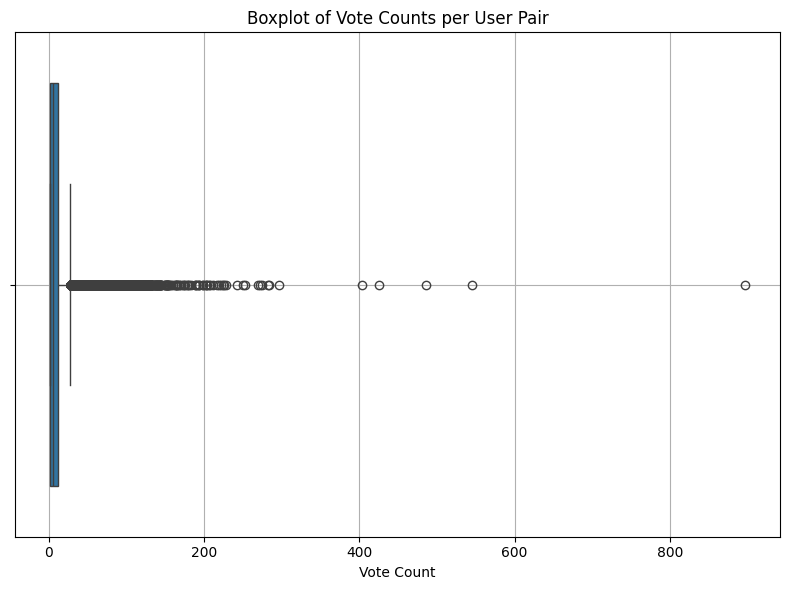

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(x=vote_counts['vote_count'])
plt.title('Boxplot of Vote Counts per User Pair')
plt.xlabel('Vote Count')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
Q1 = vote_counts['vote_count'].quantile(0.25)
Q3 = vote_counts['vote_count'].quantile(0.75)
IQR = Q3 - Q1 

# 상한 기준값
upper_bound = Q3 + 1.5 * IQR
print(upper_bound)

# 이상치 유저쌍 분리
outlier_user_pair = vote_counts[vote_counts['vote_count'] > upper_bound].sort_values(by='vote_count', ascending=False)
user_pair_without_outlier = vote_counts[vote_counts['vote_count'] <= upper_bound].sort_values(by='vote_count', ascending=False)
outlier_user_pair_count = outlier_user_pair.size
print(outlier_user_pair_count)

outlier_user_pair

27.0
18344


,user_pair,vote_count
18037,"(1132932, 1214232)",897
115709,"(907442, 952220)",545
32710,"(1206529, 1213990)",486
106115,"(884218, 952220)",425
124471,"(968333, 1401244)",404
...,...,...
945,"(1004511, 1008546)",28
62483,"(1447844, 1489677)",28
62472,"(1447844, 1481847)",28
30769,"(1186471, 1276928)",28


In [35]:
outlier_user_pair['vote_count'].unique()

array([897, 545, 486, 425, 404, 296, 283, 282, 274, 272, 270, 253, 250,
       242, 228, 225, 224, 222, 219, 217, 212, 207, 206, 204, 203, 202,
       199, 198, 194, 193, 192, 189, 188, 183, 181, 179, 178, 175, 174,
       173, 170, 168, 165, 164, 163, 160, 157, 156, 155, 154, 153, 152,
       151, 150, 148, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136,
       135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123,
       122, 121, 120, 119, 118, 117, 116, 115, 114, 113, 112, 111, 110,
       109, 108, 107, 106, 105, 104, 103, 102, 101, 100,  99,  98,  97,
        96,  95,  94,  93,  92,  91,  90,  89,  88,  87,  86,  85,  84,
        83,  82,  81,  80,  79,  78,  77,  76,  75,  74,  73,  72,  71,
        70,  69,  68,  67,  66,  65,  64,  63,  62,  61,  60,  59,  58,
        57,  56,  55,  54,  53,  52,  51,  50,  49,  48,  47,  46,  45,
        44,  43,  42,  41,  40,  39,  38,  37,  36,  35,  34,  33,  32,
        31,  30,  29,  28])

! 상호작용 회수가 일정수준을 넘어가면 서로의 존재를 아는 상태에서의 의미없는 투표활동으로 보여짐. 따라서 투표회수 상한선을 기준으로 28회 이상 사용자들부터 초성확인 기능 제공. 

#### 유저 쌍 지표 생성 (프롬프트 입력)

| 지표 이름                | 설명 |
|-------------------------|------|
| `total_votes`           | 현재까지 해당 유저쌍 간에 발생한 총 상호작용(투표) 횟수 |
| `A_to_B_count`          | A 유저가 B 유저에게 보낸 투표 횟수 |
| `B_to_A_count`          | B 유저가 A 유저에게 보낸 투표 횟수 |
| `last_vote_direction`   | 현재 투표의 방향(A→B 또는 B→A) |
| `first_vote_timestamp`  | 해당 유저쌍 간 최초로 투표가 이루어진 시각 |
| `last_vote_timestamp`   | 현재 투표가 이루어진 시각 |
| `vote_intervals`        | 지금까지의 투표 간 시간 간격들의 리스트 (단위: 초 또는 분) |
| `interaction_stage`     | 현재 유저쌍의 상호작용 단계 (`단방향`, `초기상호작용`, `반복상호작용` 등으로 분류 ) |
| `is_reciprocal`         | 해당 유저쌍이 서로에게 투표한 적이 있는지 여부 (True/False) |
| `recent_reciprocation`  | 최근 3회 내에 상호작용의 방향성이 양방향으로 나타났는지 여부 |
| `emotion_list`  | 마지막 투표까지의 감정 시퀀스 리스트 |

지표생성 함수 (2회차, 최다 등장 감정 지표 > 감정 시퀀스 리스트) 

In [35]:
import pandas as pd
import numpy as np

def generate_user_pair_progressive_metrics(df_pair): # df_pair = 각 유저쌍
    df_pair['timestamp'] = pd.to_datetime(df_pair['timestamp'])
    df_pair = df_pair.sort_values('timestamp').reset_index(drop=True)
    
    A, B = df_pair['From'].iloc[0], df_pair['To'].iloc[0]
    results = []
    emotions = [] # 감정 누적 리스트 

    gender_relation = df_pair['relation'].iloc[0] # '이성' 또는 '동성'
    

    for i in range(1, len(df_pair) + 1):
        sub_df = df_pair.iloc[:i]
        total_votes = i
        
        if total_votes > 27:  # 28회 이상 부터는 초성확인 기능으로 대체, 상세정보 요약
            results.append({
                'round': i,
                'total_votes': total_votes,
                'A_to_B_count': None,
                'B_to_A_count': None,
                'first_vote_timestamp': None,
                'last_vote_timestamp': None,
                'vote_intervals': None,
                'last_vote_direction': None,
                'interaction_stage': None,
                'is_reciprocal': None,
                'recent_reciprocation': None,
                'top_emotion': None
            })
            continue
                
        A_to_B_count = (sub_df['From'] == A).sum()
        B_to_A_count = (sub_df['From'] == B).sum()
        first_vote_timestamp = sub_df['timestamp'].iloc[0]
        last_vote_timestamp = sub_df['timestamp'].iloc[-1]
        vote_intervals = sub_df['timestamp'].diff().dt.total_seconds().div(60).dropna().tolist()
        vote_intervals = [round(x, 1) for x in vote_intervals]
        last_vote_direction = 'A->B' if sub_df['From'].iloc[-1] == A else 'B->A'
        
        if A_to_B_count == 0 or B_to_A_count == 0: # 상호작용 단계 분류
            interaction_stage = '단방향'
        elif A_to_B_count <= 2 and B_to_A_count <= 2:
            interaction_stage = '초기 상호작용'
        elif A_to_B_count >= 3 and B_to_A_count >= 3:
            interaction_stage = '반복 상호작용'
                

        is_reciprocal = A_to_B_count > 0 and B_to_A_count > 0 # 상호작용 여부
        recent_3 = sub_df.tail(3)
        recent_reciprocation = 'Yes' if recent_3['From'].nunique() > 1 else 'No'
        
        emotion = sub_df.iloc[-1]['1st'] # 감정시퀀스 추가
        if pd.notna(emotion):
            emotions.append(emotion)
        emotion_sequence = emotions.copy()    
        question_text = sub_df.iloc[-1]['question_text'] # 질문 텍스트 

        results.append({
            'round': i,
            'total_votes': total_votes,
            'gender_relation':gender_relation,
            'A_to_B_count': A_to_B_count,
            'B_to_A_count': B_to_A_count,
            'first_vote_timestamp': first_vote_timestamp,
            'last_vote_timestamp': last_vote_timestamp,
            'vote_intervals': vote_intervals,
            'last_vote_direction': last_vote_direction,
            'interaction_stage': interaction_stage,
            'is_reciprocal': is_reciprocal,
            'recent_reciprocation': recent_reciprocation,
            'emotion_sequence' : emotions,
            'question_text' : question_text
        })

    return pd.DataFrame(results)

In [36]:
user_pair_without_outlier

,user_pair,vote_count
49027,"(1327122, 1420321)",27
49064,"(1327787, 1344700)",27
5482,"(1039262, 1078393)",27
69454,"(849491, 856281)",27
95957,"(876384, 887714)",27
...,...,...
34896,"(1210808, 1214019)",1
14489,"(1112856, 1401832)",1
103436,"(882924, 954322)",1
103430,"(882924, 889291)",1


In [37]:
# 1. (1327122, 1420321) 유저쌍 추출 

df_pair_1327787_1344700 = sorted_df[sorted_df['user_pair']=='(1327787, 1344700)']
df_pair_1327787_1344700

,Unnamed: 0,From,To,From_gender,To_gender,timestamp,question_id,relation,question_text,1st,2nd,3rd,user_pair
1046945,1046945,1344700,1327787,M,M,2023-05-17 11:46:38,336,동성,제대로 놀 때 부르고 싶은 친구는?,우정,NaN,NaN,"(1327787, 1344700)"
1046946,1046946,1344700,1327787,M,M,2023-05-17 13:58:06,999,동성,얘랑 친구 아니였으면 몰래 좋아했을 것 같은 사람,NaN,NaN,NaN,"(1327787, 1344700)"
1046947,1046947,1344700,1327787,M,M,2023-05-17 15:01:57,765,동성,가장 닮고 싶은 친구는?,우정,칭찬,NaN,"(1327787, 1344700)"
1046948,1046948,1344700,1327787,M,M,2023-05-18 02:14:14,212,동성,같이 바다보러 떠나고싶은 사람은?,우정,호기심,NaN,"(1327787, 1344700)"
1046949,1046949,1344700,1327787,M,M,2023-05-18 02:14:44,383,동성,워터파크 같이 가고싶은 사람은?,우정,호기심,NaN,"(1327787, 1344700)"
1046950,1046950,1344700,1327787,M,M,2023-05-18 07:47:45,1318,동성,인스타 셀럽일 것 같은 사람은?,우정,호기심,NaN,"(1327787, 1344700)"
1046951,1046951,1344700,1327787,M,M,2023-05-18 07:48:39,914,동성,예술감각이 가장 뛰어난 친구는?,우정,칭찬,NaN,"(1327787, 1344700)"
1046952,1046952,1344700,1327787,M,M,2023-05-18 13:48:48,673,동성,체육대회때 이인삼각 뛴다면 누구랑 뛰고 싶어?,우정,NaN,NaN,"(1327787, 1344700)"
1046953,1046953,1327787,1344700,M,M,2023-05-18 23:44:58,626,동성,고백하면 받아줄 수 있는 사람은?,우정,호기심,NaN,"(1327787, 1344700)"
1046954,1046954,1344700,1327787,M,M,2023-05-19 05:25:32,222,동성,봄날 같이 피크닉 떠나고 싶은 사람은?,우정,호기심,NaN,"(1327787, 1344700)"


In [38]:
# 지표생성 함수 적용

df_pair_1327787_1344700_history = generate_user_pair_progressive_metrics(df_pair_1327787_1344700)
df_pair_1327787_1344700_history

/tmp/ipykernel_1464873/98870566.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pair['timestamp'] = pd.to_datetime(df_pair['timestamp'])


,round,total_votes,gender_relation,A_to_B_count,B_to_A_count,first_vote_timestamp,last_vote_timestamp,vote_intervals,last_vote_direction,interaction_stage,is_reciprocal,recent_reciprocation,emotion_sequence,question_text
0,1,1,동성,1,0,2023-05-17 11:46:38,2023-05-17 11:46:38,[],A->B,단방향,False,No,"[우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우...",제대로 놀 때 부르고 싶은 친구는?
1,2,2,동성,2,0,2023-05-17 11:46:38,2023-05-17 13:58:06,[131.5],A->B,단방향,False,No,"[우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우...",얘랑 친구 아니였으면 몰래 좋아했을 것 같은 사람
2,3,3,동성,3,0,2023-05-17 11:46:38,2023-05-17 15:01:57,"[131.5, 63.9]",A->B,단방향,False,No,"[우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우...",가장 닮고 싶은 친구는?
3,4,4,동성,4,0,2023-05-17 11:46:38,2023-05-18 02:14:14,"[131.5, 63.9, 672.3]",A->B,단방향,False,No,"[우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우...",같이 바다보러 떠나고싶은 사람은?
4,5,5,동성,5,0,2023-05-17 11:46:38,2023-05-18 02:14:44,"[131.5, 63.9, 672.3, 0.5]",A->B,단방향,False,No,"[우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우...",워터파크 같이 가고싶은 사람은?
5,6,6,동성,6,0,2023-05-17 11:46:38,2023-05-18 07:47:45,"[131.5, 63.9, 672.3, 0.5, 333.0]",A->B,단방향,False,No,"[우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우...",인스타 셀럽일 것 같은 사람은?
6,7,7,동성,7,0,2023-05-17 11:46:38,2023-05-18 07:48:39,"[131.5, 63.9, 672.3, 0.5, 333.0, 0.9]",A->B,단방향,False,No,"[우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우...",예술감각이 가장 뛰어난 친구는?
7,8,8,동성,8,0,2023-05-17 11:46:38,2023-05-18 13:48:48,"[131.5, 63.9, 672.3, 0.5, 333.0, 0.9, 360.1]",A->B,단방향,False,No,"[우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우...",체육대회때 이인삼각 뛴다면 누구랑 뛰고 싶어?
8,9,9,동성,8,1,2023-05-17 11:46:38,2023-05-18 23:44:58,"[131.5, 63.9, 672.3, 0.5, 333.0, 0.9, 360.1, 5...",B->A,단방향,True,Yes,"[우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우...",고백하면 받아줄 수 있는 사람은?
9,10,10,동성,9,1,2023-05-17 11:46:38,2023-05-19 05:25:32,"[131.5, 63.9, 672.3, 0.5, 333.0, 0.9, 360.1, 5...",A->B,단방향,True,Yes,"[우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우정, 우...",봄날 같이 피크닉 떠나고 싶은 사람은?


In [62]:
import os
import time
import json
import pandas as pd
import google.generativeai as genai
from dotenv import load_dotenv

def generate_messages(df, batch_size=5, sleep_sec=1):
    # 1. 환경변수 로드 및 모델 설정
    load_dotenv()
    genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))
    model = genai.GenerativeModel(model_name="models/gemini-1.5-pro")

    # 2. 단일 배치 처리 함수 정의
    def generate_message(df_pair):
        df_copy = df_pair.copy()
        for col in df_copy.columns:
            if pd.api.types.is_datetime64_any_dtype(df_copy[col]):
                df_copy[col] = df_copy[col].dt.strftime('%Y-%m-%d %H:%M:%S')

        def convert_to_serializable(obj):
            if isinstance(obj, pd.Timestamp):
                return obj.strftime('%Y-%m-%d %H:%M:%S')
            elif isinstance(obj, pd.Timedelta):
                return str(obj.total_seconds())
            elif isinstance(obj, list):
                return [convert_to_serializable(i) for i in obj]
            elif isinstance(obj, dict):
                return {k: convert_to_serializable(v) for k, v in obj.items()}
            else:
                return obj

        data_list = [convert_to_serializable(record) for record in df_copy.to_dict(orient='records')]

        system_prompt = """
        당신은 감정적으로 섬세하고 맥락을 잘 이해하는 어시스턴트입니다.

        현재 우리는 익명 투표앱을 운영 중이며, 사용자는 특정 질문에 대해 다른 사용자에게 투표할 수 있습니다.  
        투표를 받은 사용자는 투표자의 정체를 알 수 없지만, 투표를 받을 때마다 생성된 특정문구를 전달받습니다.  

        당신은 json 형태의 데이터를 기반으로 두 사용자 간의 감정적 흐름과 상호작용 패턴을 분석하고,  
        각 투표마다 사용자에게 보여줄 감정 서사 기반 문구를 **전지적 관찰자 시점**에서 생성하는 역할을 합니다. 문구는 질문 텍스트를 반영해 생성해주세요.

        중고등학생을 대상으로 하는 앱이므로 문장은 트렌디하고 캐주얼해야 하며, 친근한 어투로 표현해줘.  
        반복적인 상호작용이나 감정의 누적, 양방향성의 발생 등은 관계발전으로 문장에 자연스럽게 반영되어야 합니다.  
        
        문장은 의미심장하고 감정적으로 여운을 남겨야 하며,  
        특히 상호작용이 양방향으로 발생한 이후에는 서로를 점점 더 의식하게 되는 분위기를 암시해야 합니다.

        생성되는 문구에서는 투표한 사용자나 투표받은 사용자를 특정하여 지칭하지 마세요. "A", "B"와 같은 명칭 대신, 익명의 관계 속에서 발생하는 감정과 변화를 중심으로 서술해 주세요.
        
        당신의 응답은 입력받은 JSON 리스트 각 항목마다 대응되는 문구가 포함된 JSON 리스트 형태여야 합니다.  
        각 항목에 "generated_message"라는 key를 추가하여 해당 문장을 포함시켜 주세요.

        generated_message는 반드시 연애나 이성적 관심을 나타낼 필요는 없으며, 동성 관계라면 로맨스적 뉘앙스보다 우정의 뉘앙스를 강조하여 사회적 맥락에 맞춰 자연스럽게 표현해 주세요.

        
        데이터내 각 컬럼의 의미는 다음과 같습니다.

        'total_votes' - 현재까지 해당 유저쌍 간에 발생한 총 상호작용(투표) 횟수  
        'gender_relation' - '이성' 또는 '동성'  
        'A_to_B_count' - A 유저가 B 유저에게 보낸 투표 횟수  
        'B_to_A_count' - B 유저가 A 유저에게 보낸 투표 횟수  
        'last_vote_direction' - 현재 투표의 방향 (A→B 또는 B→A)  
        'first_vote_timestamp' - 해당 유저쌍 간 최초로 투표가 이루어진 시각  
        'last_vote_timestamp' - 현재 투표가 이루어진 시각  
        'vote_intervals' - 지금까지의 투표 간 시간 간격들의 리스트 (단위: 초 또는 분)  
        'interaction_stage' - 현재 유저쌍의 상호작용 단계 ('단방향', '초기상호작용', '반복상호작용' 등으로 분류)  
        'is_reciprocal' - 해당 유저쌍이 서로에게 투표한 적이 있는지 여부 (True 또는 False)  
        'recent_reciprocation' - 최근 3회 내에 상호작용의 방향성이 양방향으로 나타났는지 여부  
        'emotion_list' - 마지막 투표까지의 감정 시퀀스 리스트  
        'question_text' - 질문 텍스트 
        
        
        응답 형식 예시는 다음과 같습니다:

        [
        {
            "total_votes": 1,
            "A_to_B_count": 1,
            ...
            "generated_message": "😂너를 생각하면 웃음이 나는 사람이 있나 봐! ..."
        },
        ...
        ]
        이 형식을 정확히 따라주세요.
        """

        response = model.generate_content(
            [
                {"role": "user", "parts": [system_prompt]},
                {"role": "user", "parts": [
                    "다음 JSON 리스트에 대해 각 항목별로 감정적 서사 문장을 'generated_message' 필드에 넣어 반환해주세요.",
                    json.dumps(data_list, ensure_ascii=False)
                ]}
            ],
            generation_config={
                "temperature": 0.9,
                "top_p": 1.0,
                "top_k": 40,
                "max_output_tokens": 2048
            }
        )

        try:
            result = json.loads(response.text)
            result_df = pd.DataFrame(result)
            return pd.concat([df_pair.reset_index(drop=True), result_df[['generated_message']]], axis=1)
        except Exception as e:
            print("⚠️ JSON 파싱 오류 발생:", e)
            print("Gemini 응답 내용:\n", response.text)

            import re
            messages = re.findall(r'"generated_message"\s*:\s*"([^"]+)"', response.text)
            if messages:
                while len(messages) < len(df_pair):
                    messages.append("")
                return df_pair.reset_index(drop=True).assign(generated_message=messages[:len(df_pair)])
            else:
                return df_pair.reset_index(drop=True).assign(generated_message="메시지 생성 실패")

    # 3. 전체 배치 처리 루프
    all_results = []
    num_rows = len(df)

    for start in range(0, num_rows, batch_size):
        end = min(start + batch_size, num_rows)
        batch_df = df.iloc[start:end]
        print(f"📦 Processing batch {start} to {end}...")

        try:
            result = generate_message(batch_df)
            all_results.append(result)
        except Exception as e:
            print(f"❌ Error in batch {start}-{end}: {e}")
            fallback_df = batch_df.copy()
            fallback_df["generated_message"] = "메시지 생성 실패"
            all_results.append(fallback_df)

        time.sleep(sleep_sec)

    return pd.concat(all_results, ignore_index=True)

In [53]:
random_5pairs_df

,user_pair,vote_count
20704,"(1139561, 1192085)",4
59437,"(1424480, 1450864)",2
78933,"(859291, 864897)",7
56156,"(1411753, 1472404)",1
53027,"(1402393, 1416626)",11


In [54]:
df_pair_859291_864897 = sorted_df[sorted_df['user_pair']=='(859291, 864897)']
df_pair_859291_864897_history = generate_user_pair_progressive_metrics(df_pair_859291_864897)

/tmp/ipykernel_1464873/98870566.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pair['timestamp'] = pd.to_datetime(df_pair['timestamp'])


In [66]:
result_859291_864897 = generate_messages(df_pair_859291_864897_history)

📦 Processing batch 0 to 5...
⚠️ JSON 파싱 오류 발생: Expecting value: line 1 column 1 (char 0)
Gemini 응답 내용:
 ```json
[
    {
        "round": 1,
        "total_votes": 1,
        "gender_relation": "동성",
        "A_to_B_count": 1,
        "B_to_A_count": 0,
        "first_vote_timestamp": "2023-05-01 15:05:35",
        "last_vote_timestamp": "2023-05-01 15:05:35",
        "vote_intervals": [],
        "last_vote_direction": "A->B",
        "interaction_stage": "단방향",
        "is_reciprocal": false,
        "recent_reciprocation": "No",
        "emotion_sequence": ["우정", "우정", "호기심", "칭찬", "호기심", "우정", "칭찬"],
        "question_text": "여행을 가서 사진을 찍어달라고 맡기고 싶은 사람은?",
        "generated_message": "📸 누군가 너의 인생샷을 책임져주고 싶대! 여행 가서 사진 찍어달라고 맡기고 싶은 사람으로 뽑혔다는 건... 🤔  뭔가 센스있고, 너를 잘 알아줄 것 같은 느낌적인 느낌?"
    },
    {
        "round": 2,
        "total_votes": 2,
        "gender_relation": "동성",
        "A_to_B_count": 2,
        "B_to_A_count": 0,
        "first_vote_timestamp": "2023-05-01 15:05:35",
    

In [64]:
df_pair_1577440_1577437 = sorted_df[sorted_df['user_pair']=='(1577437, 1577440)']
df_pair_1577440_1577437_history = generate_user_pair_progressive_metrics(df_pair_1577440_1577437)
result_1577440_1577437 =  generate_messages(df_pair_1577440_1577437_history)

/tmp/ipykernel_1464873/98870566.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pair['timestamp'] = pd.to_datetime(df_pair['timestamp'])


📦 Processing batch 0 to 5...
⚠️ JSON 파싱 오류 발생: Expecting value: line 1 column 1 (char 0)
Gemini 응답 내용:
 ```json
[
{
    "round": 1,
    "total_votes": 1,
    "gender_relation": "이성",
    "A_to_B_count": 1,
    "B_to_A_count": 0,
    "first_vote_timestamp": "2023-06-29 09:04:19",
    "last_vote_timestamp": "2023-06-29 09:04:19",
    "vote_intervals": [],
    "last_vote_direction": "A->B",
    "interaction_stage": "단방향",
    "is_reciprocal": false,
    "recent_reciprocation": "No",
    "emotion_sequence": ["호기심", "칭찬", "호기심", "이성적 관심", "호기심", "호기심", "칭찬", "이성적 관심", "호기심", "우정", "우정", "이성적 관심", "이성적 관심", "호기심", "호기심", "호기심", "우정", "호기심", "우정", "우정"],
    "question_text": "침대에 인형 가득 쌓아놓을 것 같은 사람은?",
    "generated_message": "🧸 침대 가득 쌓인 곰돌이처럼, 누군가에게 포근한 인상을 남겼나 봐요! 첫인상, 꽤 괜찮았던 거 같죠? 😉"
},
{
    "round": 2,
    "total_votes": 2,
    "gender_relation": "이성",
    "A_to_B_count": 2,
    "B_to_A_count": 0,
    "first_vote_timestamp": "2023-06-29 09:04:19",
    "last_vote_timestamp": "2023-06-29 

In [67]:
result_1577440_1577437.columns

Index(['round', 'total_votes', 'gender_relation', 'A_to_B_count',
       'B_to_A_count', 'first_vote_timestamp', 'last_vote_timestamp',
       'vote_intervals', 'last_vote_direction', 'interaction_stage',
       'is_reciprocal', 'recent_reciprocation', 'emotion_sequence',
       'question_text', 'generated_message'],
      dtype='object')

In [70]:
result_1577440_1577437[['round','last_vote_direction', 'question_text','generated_message',  'last_vote_timestamp' ]]

,round,last_vote_direction,question_text,generated_message,last_vote_timestamp
0,1,A->B,침대에 인형 가득 쌓아놓을 것 같은 사람은?,"🧸 침대 가득 쌓인 곰돌이처럼, 누군가에게 포근한 인상을 남겼나 봐요! 첫인상, 꽤...",2023-06-29 09:04:19
1,2,A->B,끈기가 제일 좋은 사람은?,💪🏻 누군가 당신의 끈기에 주목했어요! 쉽게 포기하지 않는 모습이 멋있어 보였나...,2023-06-29 10:10:40
2,3,B->A,눈물이 많은 친구는?,"💧 서로에게 투표했네요! 눈물이 많다는 건, 그만큼 감수성이 풍부하다는 뜻이기도...",2023-06-30 05:16:09
3,4,B->A,새해 첫날에 보고 싶은 친구는?,"🎉 새해 첫날부터 보고 싶을 만큼, 특별한 존재가 되었나 봐요! 서로를 향한 투...",2023-06-30 05:17:15
4,5,A->B,가장 김밥을 잘 만들 것 같은 사람은?,🍙 김밥처럼 둘 사이에 뭔가 꽁꽁 싸매진 비밀이 있는 것 같아요! 투표할 때마다...,2023-06-30 06:21:51
5,6,B->A,과거로 돌아간다면 더 빨리 친해지고 싶은 친구는?,"과거로 돌아가 다시 시작하고 싶을 만큼 특별한 인연이라니, 시간을 거슬러 마음이 전...",2023-07-11 14:48:16
6,7,B->A,눈이 제일 큰 사람은?,"👀 끌리는 눈빛, 묘한 분위기! 눈에 띄는 매력을 가진 사람에게 시선이 집중되는 ...",2023-07-11 14:49:26
7,8,B->A,너와 모든 순간순간을 함께하고 싶어,모든 순간을 함께하고 싶다는 진심이 전해졌어요.💖 시간이 쌓일수록 더욱 깊어지는 ...,2023-07-11 16:00:43
8,9,B->A,가장 감성이 풍부하다고 생각하는 사람은?,"섬세한 감수성, 마음이 통하는 느낌. 깊은 감정을 공유할 수 있는 사람이 있다는 ...",2023-08-30 09:07:04
9,10,B->A,가장 열심히 사는 것 같은 사람은?,,2023-08-30 14:11:32
